In [1]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import glob
import pickle
from moviepy.editor import VideoFileClip
from camera_calibration import CameraCalibration
from birdseye import BirdsEye
from threshold import Thresholding
from lane_detection import LaneDetection
from line import Line
%matplotlib inline

# 1. Camera Calibration

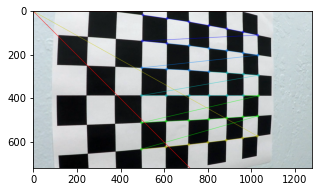

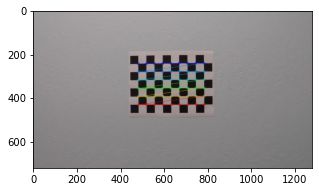

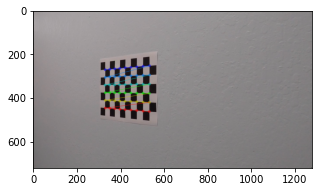

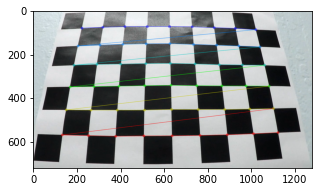

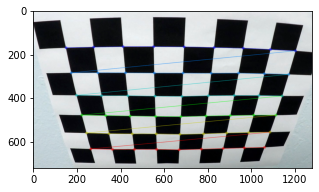

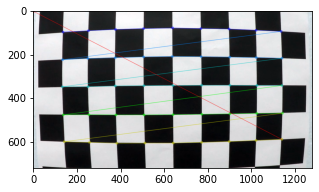

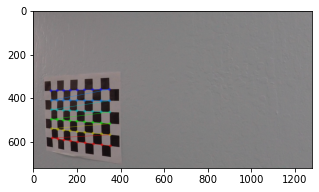

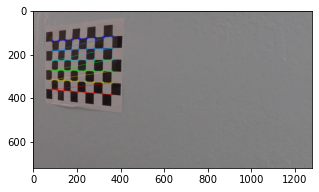

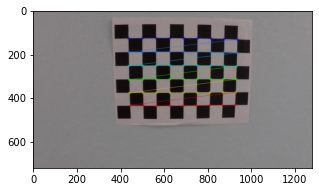

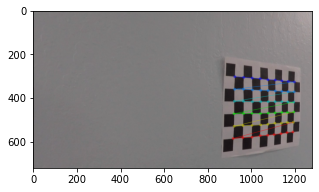

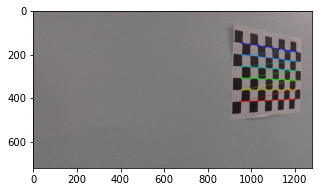

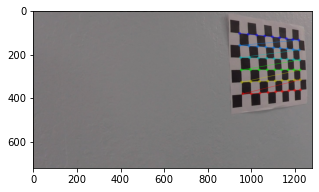

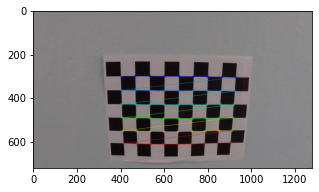

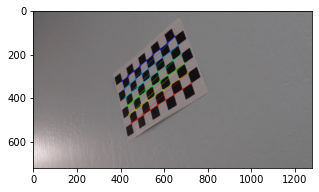

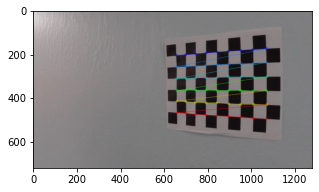

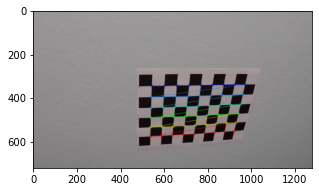

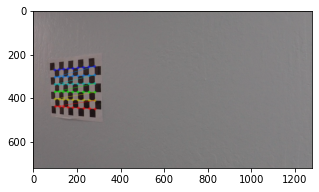

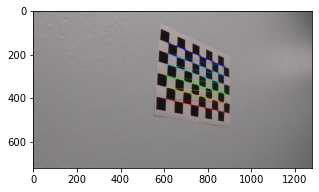

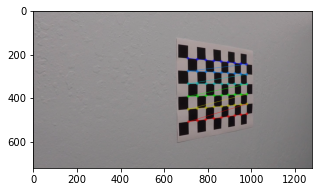

In [2]:
# Calibrating the car camera using chessboard corners detection.

directory = 'camera_cal/'
images = glob.glob(os.path.join(directory, 'calibration*.jpg'))

cam_cal = CameraCalibration()

mtx, dist = cam_cal.camera_calibration(images, nx = 9, ny = 6, draw = True)

## Save the camera calibration result as a pickle

In [3]:
cal_pickle = {}
cal_pickle['mtx'] = mtx
cal_pickle['dist'] = dist
with open('camera_cal/cal_pickle.p','wb') as output_file:
    pickle.dump(cal_pickle, output_file)

## Load the camera calibration pickle

In [4]:
with open('camera_cal/cal_pickle.p', 'rb') as input_file:
    p = pickle.load(input_file)
mtx = p['mtx']
dist = p['dist']

# 2. Distortion Correction

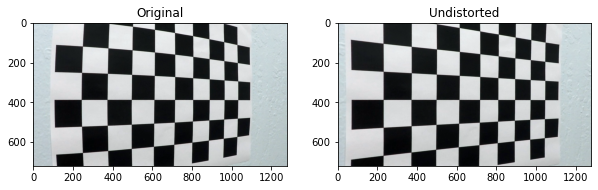

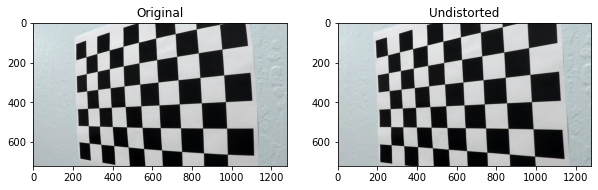

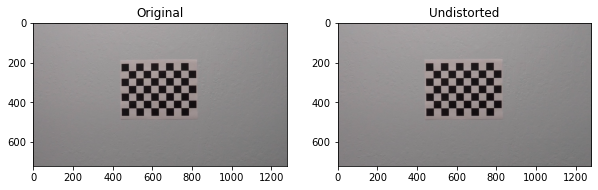

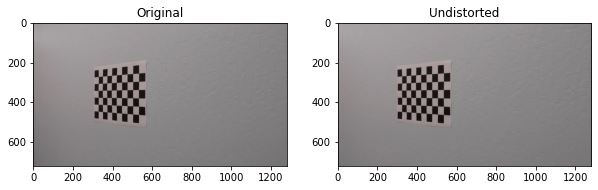

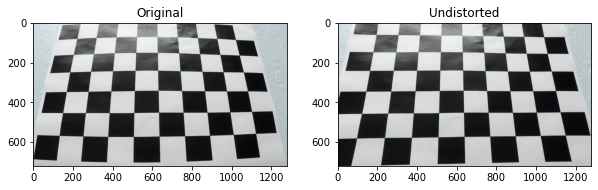

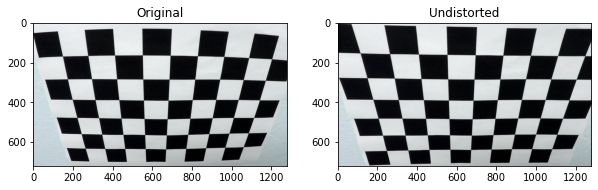

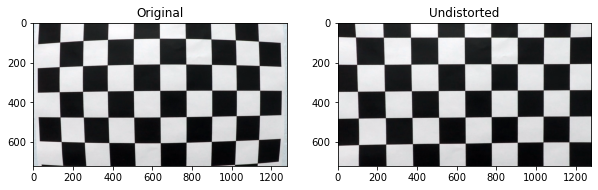

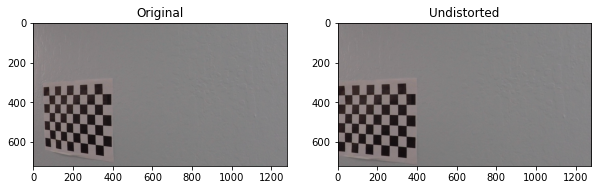

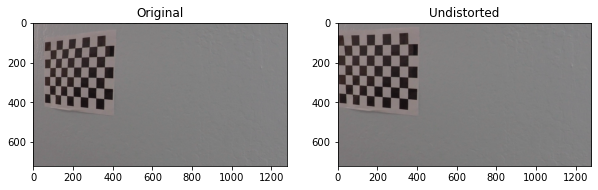

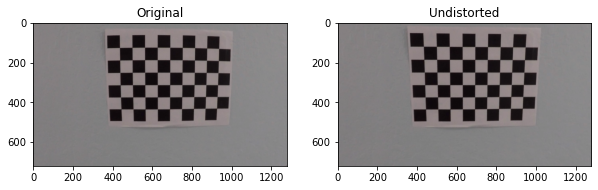

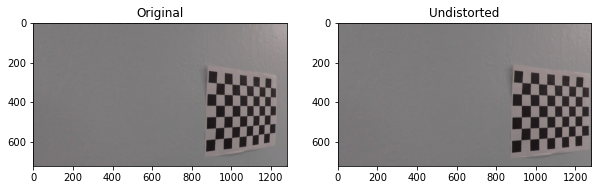

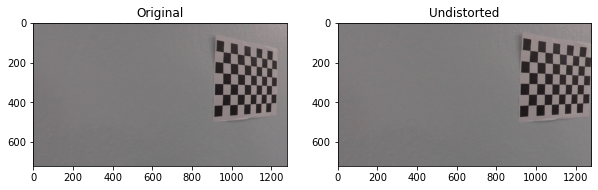

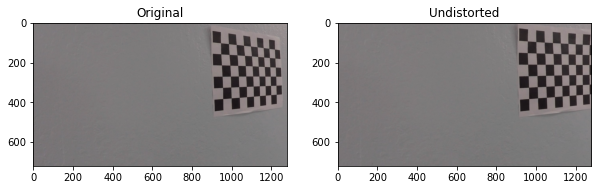

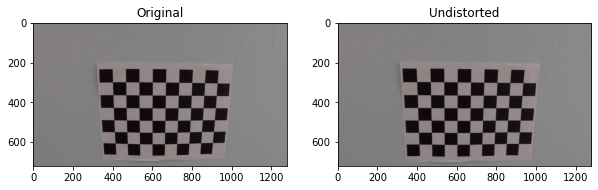

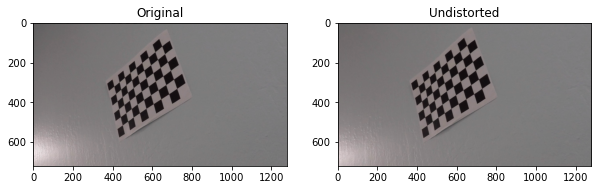

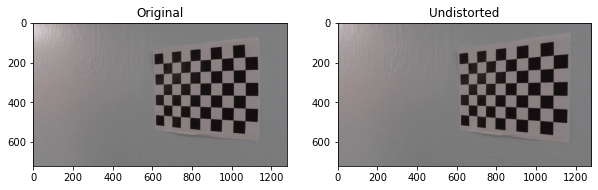

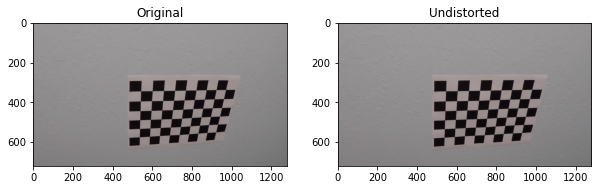

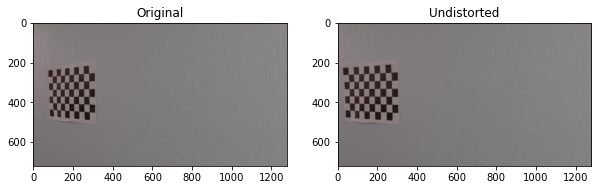

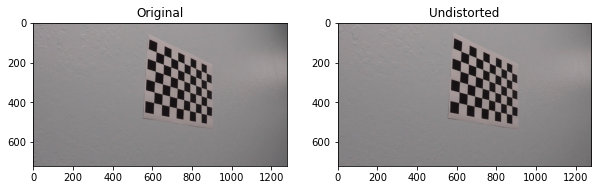

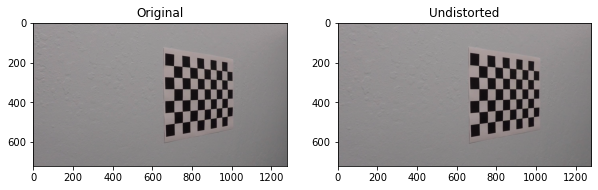

In [5]:
# Trying distortion on calibration images first
cal_imgs = glob.glob(os.path.join('camera_cal/', 'calibration*'))
for fname in cal_imgs:
    img = cv2.imread(fname)
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    f, ax = plt.subplots(1, 2, figsize=(10,8))
    ax[0].imshow(img)
    ax[0].set_title('Original')
    ax[1].imshow(undist)
    ax[1].set_title('Undistorted')
plt.show()

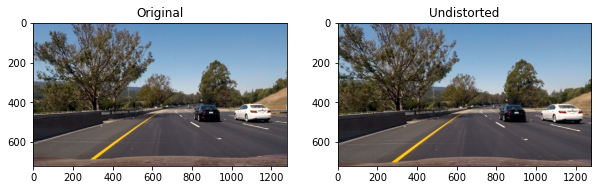

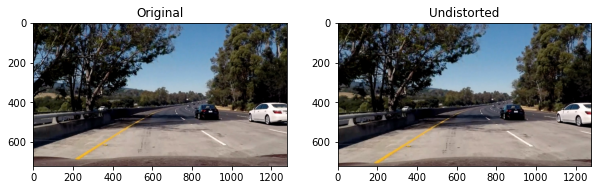

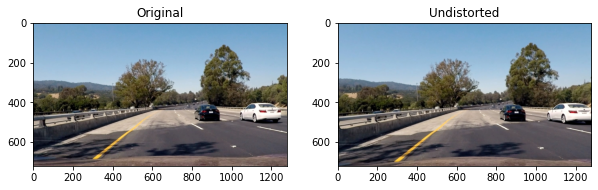

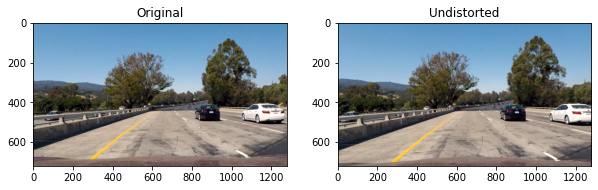

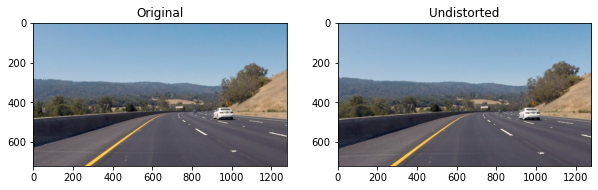

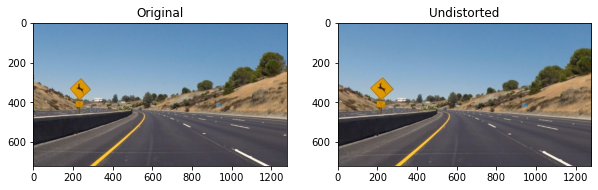

In [6]:
# Applying distortion on the test images
test_imgs = glob.glob(os.path.join('test_images/', 'test*.jpg'))
for fname in test_imgs:
    # Get the original image
    img = cv2.cvtColor(cv2.imread(fname), cv2.COLOR_BGR2RGB)
    # Get the undistorted image
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    f, ax = plt.subplots(1, 2, figsize=(10, 8))
    ax[0].imshow(img)
    ax[0].set_title('Original')
    ax[1].imshow(undist)
    ax[1].set_title('Undistorted')
plt.show()

# 3. Perspective Transform

First, transfrom on the undistorted figures.

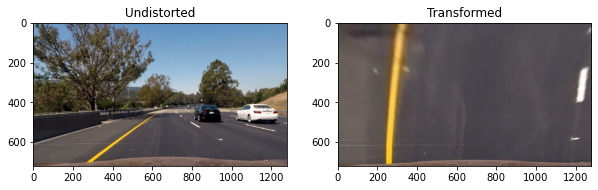

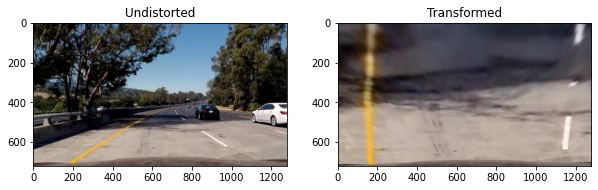

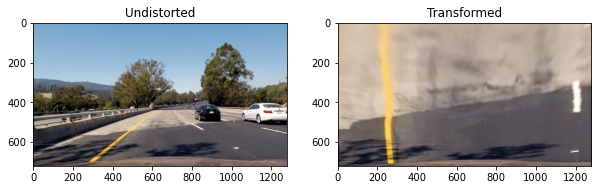

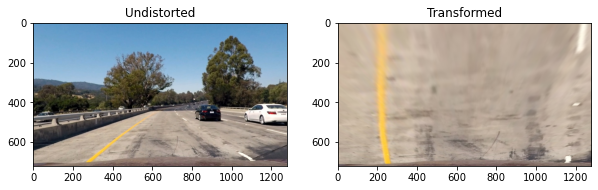

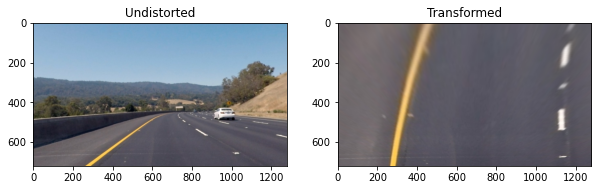

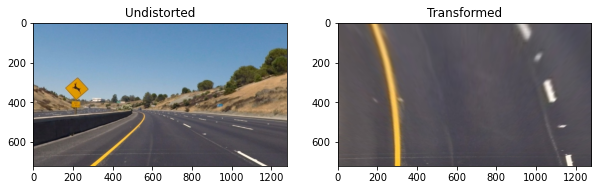

In [7]:
# pixel numbers for the images
src = np.float32([(300,720),(1100,720),(730,480),(580,480)])
dst = np.float32([(300,720),(1100,720),(1100,0),(300,0)])

birdseye = BirdsEye(src, dst)

# Get the transform matrices 
M, Minv = birdseye.PerspectiveTransform()

# Grab all the test images
test_imgs = glob.glob(os.path.join('test_images/', 'test*.jpg'))
for fname in test_imgs:
    # Get the original image
    img = cv2.cvtColor(cv2.imread(fname), cv2.COLOR_BGR2RGB)
    undist = cv2.undistort(img, mtx, dist, None, mtx)    
    birdseyeView = cv2.warpPerspective(undist, M, (img.shape[1], img.shape[0]), flags=cv2.INTER_LINEAR)
    f, ax = plt.subplots(1, 2, figsize=(10,8))
    ax[0].imshow(undist)
    ax[0].set_title('Undistorted')
    ax[1].imshow(birdseyeView)
    ax[1].set_title('Transformed')
plt.show()

# 4. Thresholding

In [8]:
# Define a function that takes an image, gradient orientation,
# and threshold min / max values.
def abs_sobel_thresh(img, orient = 'x', thresh_min = 0, thresh_max = 255):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0))
    elif orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy of the image
    binary = np.zeros_like(scaled_sobel)
    # Apply the threshold
    binary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
    return binary

def thresholding(img, s_thresh=(170, 255), sx_thresh=(30, 255)):   
    # Sobel x 
    sobel_x = abs_sobel_thresh(img, 'x', 30, 255)
    
    # White and yellow from RGB
    rgb_white = cv2.inRange(img, (200, 200, 200), (255, 255, 255))
    rgb_yellow = cv2.inRange(img, (20, 100, 100), (50, 255, 255))
    
    # White and yellow from HSV
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    hsv_white = cv2.inRange(hsv, (200, 200, 200), (255, 255, 255))
    hsv_yellow = cv2.inRange(hsv, (20, 100, 100), (50, 255, 255))
    
    # S channel from HLS
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s = hls[:,:,2]
    s_output = np.zeros_like(s)
    s_output[(s > 170) & (s <= 255)] = 1
    
    # White and yellow from HLS
    hls_white = cv2.inRange(hls, (200,200,200), (255,255,255))
    hls_yellow = cv2.inRange(hls, (20, 100, 100), (50, 255, 255))

    masked = sobel_x | s_output | rgb_white | rgb_yellow | hsv_white | hsv_yellow | hls_white | hls_yellow
    return masked    

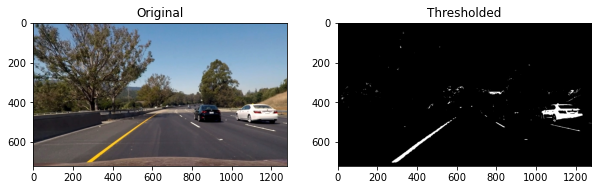

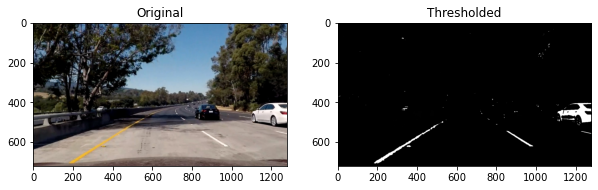

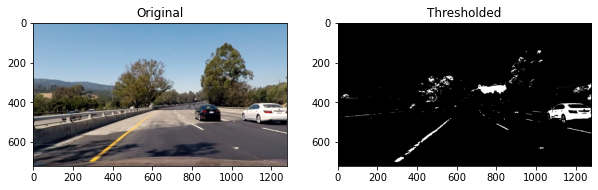

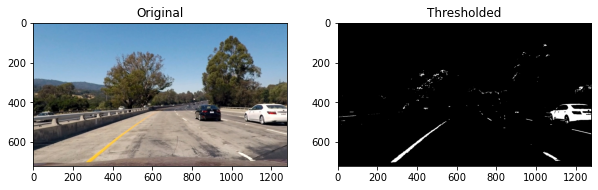

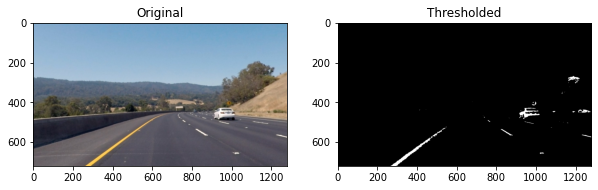

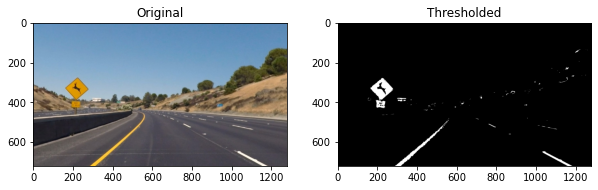

In [9]:
#Applying threshold on undistorted image

test_imgs = glob.glob(os.path.join('test_images/', 'test*.jpg'))
for fname in test_imgs:
    img = cv2.cvtColor(cv2.imread(fname), cv2.COLOR_BGR2RGB)
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    masked = thresholding(undist, 'x')
    f, ax = plt.subplots(1, 2, figsize=(10,8))
    ax[0].imshow(undist)
    ax[0].set_title('Original')
    ax[1].imshow(masked, cmap = 'gray')
    ax[1].set_title('Thresholded')
    plt.show()

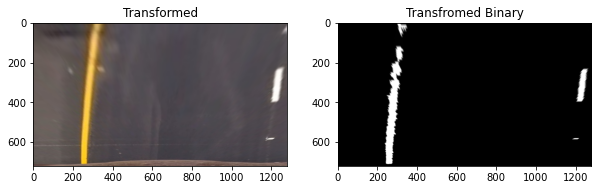

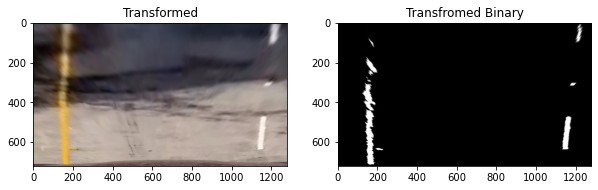

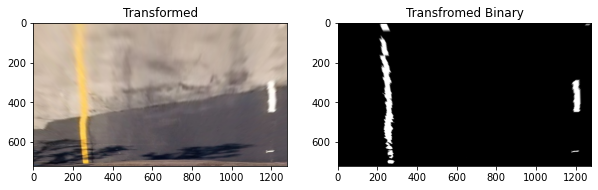

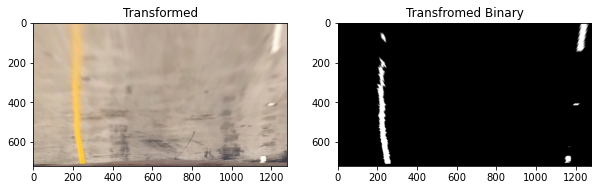

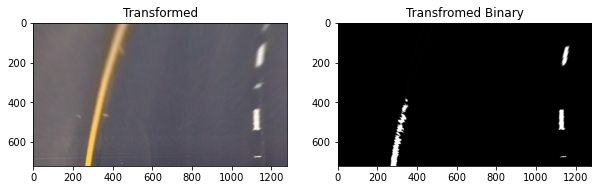

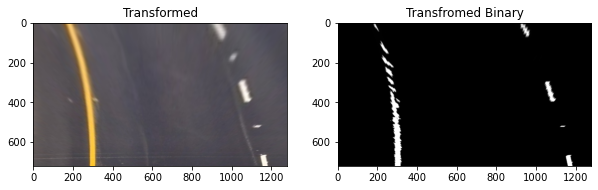

In [10]:
# Apply threshold on skyview images
# Grab all the test images
test_imgs = glob.glob(os.path.join('test_images/', 'test*.jpg'))
for fname in test_imgs:
    img = cv2.cvtColor(cv2.imread(fname), cv2.COLOR_BGR2RGB)
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    masked = thresholding(undist)
    transformed = cv2.warpPerspective(undist, M, (1280, 720), flags=cv2.INTER_LINEAR)
    binary_transformed = cv2.warpPerspective(masked, M, (1280, 720), flags=cv2.INTER_LINEAR)
    f, ax = plt.subplots(1, 2, figsize=(10,8))
    ax[0].imshow(transformed)
    ax[0].set_title('Transformed')
    ax[1].imshow(binary_transformed, cmap = 'gray')
    ax[1].set_title('Transfromed Binary')
    plt.show()

# 5. Lane Detection

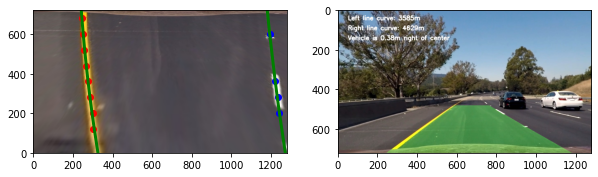

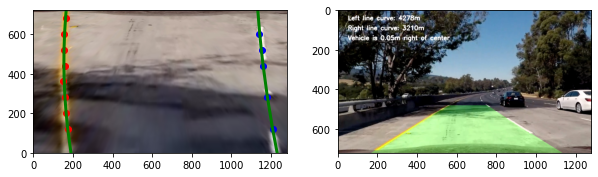

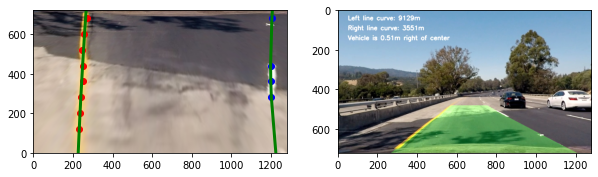

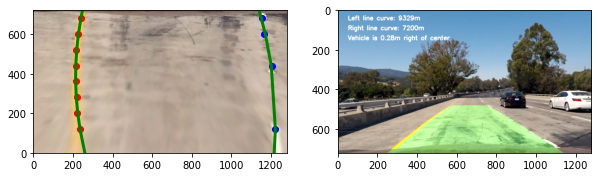

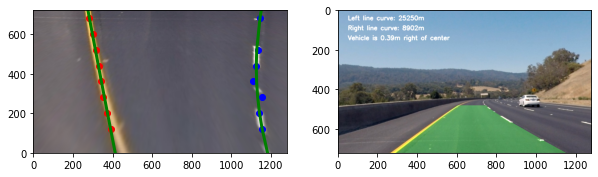

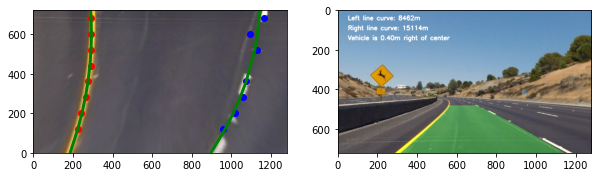

In [11]:
# Define conversions in x and y from pixels space to meters
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meteres per pixel in x dimension

lane_detection = LaneDetection(ym_per_pix, xm_per_pix, Minv)

# Grab all the test images
test_imgs = glob.glob(os.path.join('test_images/', 'test*.jpg'))
for fname in test_imgs:
    # Get the original image
    img = cv2.cvtColor(cv2.imread(fname), cv2.COLOR_BGR2RGB)
    
    # Get the undistorted image
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    
    #Applying threshold
    transformed = thresholding(undist)
    
    #Getting birdseye
    birdseye_undist = cv2.warpPerspective(undist, M, (img.shape[1], img.shape[0]), flags=cv2.INTER_LINEAR)
    birdseye_transformed = cv2.warpPerspective(transformed, M, (img.shape[1], img.shape[0]), flags=cv2.INTER_LINEAR)
    
    result, left_x, left_y, right_x, right_y, left_fitx, left_y_ext, right_fitx, right_y_ext = \
    lane_detection.FindLines(birdseye_transformed,undist, 80)
    
    f, ax = plt.subplots(1, 2, figsize=(10,8))
    ax[0].imshow(birdseye_undist)
    ax[0].scatter(left_x, left_y, c = 'r')
    ax[0].scatter(right_x, right_y, c = 'b')
    ax[0].plot(left_fitx, left_y_ext, color='green', linewidth=3)
    ax[0].plot(right_fitx, right_y_ext, color='green', linewidth=3)
    ax[0].set_xlim([0, 1280])
    ax[0].set_ylim([0, 720])
    ax[1].imshow(result)
    plt.show()

# 6. Form the pipeline

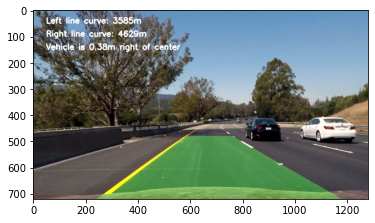

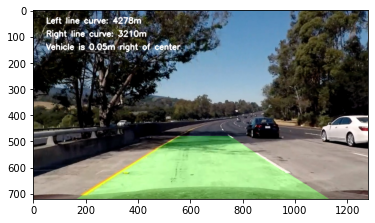

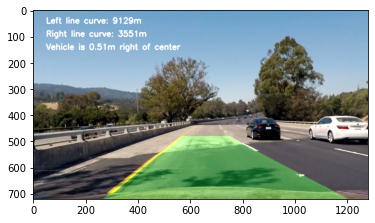

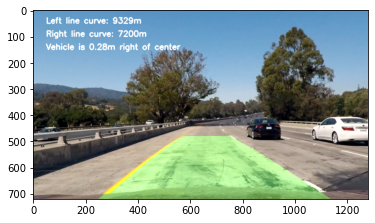

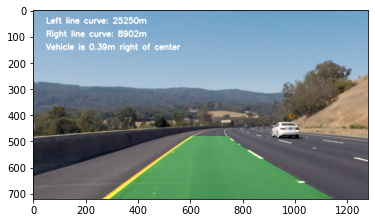

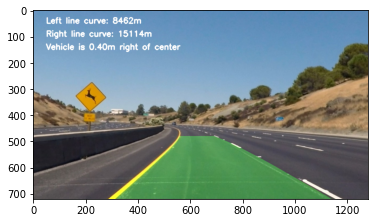

In [12]:
def pipeline(img):
    lane_detection = LaneDetection(ym_per_pix, xm_per_pix, Minv)
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    transformed = thresholding(undist)
    birdseye_transformed = cv2.warpPerspective(transformed, M, (img.shape[1], img.shape[0]), flags=cv2.INTER_LINEAR)
    result, left_x, left_y, right_x, right_y, left_fitx, left_y_ext, right_fitx, right_y_ext = \
    lane_detection.FindLines(birdseye_transformed,undist, 80)
    return result


#Testing the pipeline on test images

# Grab all the test images
test_imgs = glob.glob(os.path.join('test_images/', 'test*.jpg'))

for fname in test_imgs:
    img = cv2.cvtColor(cv2.imread(fname),cv2.COLOR_BGR2RGB)
    result = pipeline(img)
    plt.figure()
    plt.imshow(result)
    plt.show()

In [13]:
# Identifying lanes on the actual input video


clip1 = VideoFileClip("videos/project_video.mp4")
project_clip = clip1.fl_image(pipeline)

%time project_clip.write_videofile('videos/proc_project_video.mp4', audio=False)

t:   0%|          | 2/1260 [00:00<01:15, 16.66it/s, now=None]

Moviepy - Building video videos/proc_project_video.mp4.
Moviepy - Writing video videos/proc_project_video.mp4



Moviepy - Done !
Moviepy - video ready videos/proc_project_video.mp4
CPU times: user 2min 40s, sys: 18.3 s, total: 2min 58s
Wall time: 2min 50s
